In [76]:
import sys
sys.path.append('..')
from dataloader.datamodule_ecog2ph import ECoGPhonemeDataset, ECoGPhonemeDataModule
import numpy as np
import torch
from utils.utils import load_model
from model.phoneme_ctc import SpeechModel
import time
import tqdm
import torchaudio
import matplotlib.pyplot as plt
from pathlib import Path

In [77]:
device = 'cuda'

model,cfg = load_model('../outputs/2023-10-02/08-13-46/phoneme_ctc_tm1k',
                       MODEL=SpeechModel, mode='best')

model = model.net.eval().to(device)

datamodule = ECoGPhonemeDataModule(**cfg['data'])

In [154]:
ecog_files = [f for f,_ in datamodule._load_data('test')]

In [155]:
#ecog_file = ecog_files[8]

In [201]:
fi =100

In [202]:
ecog_file =Path(f'/home/cheoljun/bravo_packaged_data/tm1k/hgr_{fi}.npy')

In [238]:
ecog = np.load(ecog_file)[100:]
ecog = ECoGPhonemeDataset._preprocess(ecog)
ecog_len = torch.tensor([len(ecog)])
ecog = torch.tensor(ecog).unsqueeze(0).to(device).float()


with torch.no_grad():
    logits, _, logit_lens = model.transcriber(ecog, ecog_len)

phpos=logits[:,0].cpu().softmax(-1).numpy()

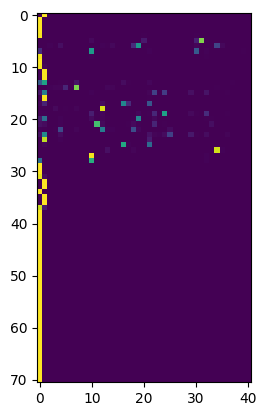

In [239]:
plt.imshow(phpos)

In [217]:
#ecog_file

confmat_all = None
cnt = 0
for ecog_file in ecog_files:
    ecog = np.load(ecog_file)
    ecog = ECoGPhonemeDataset._preprocess(ecog)
    ecog_len = torch.tensor([len(ecog)])
    ecog = torch.tensor(ecog).unsqueeze(0).to(device).float()


    with torch.no_grad():
        logits, _, logit_lens = model.transcriber(ecog, ecog_len)

    phpos=logits[:,0].cpu().softmax(-1).numpy()
    uncertain_timepoints = phpos.max(-1)<0.5
    phpos = phpos[uncertain_timepoints][:,2:]
    confmat = (phpos[:,None,:]*phpos[:,:,None]).sum(0)

    for i in range(len(confmat)):
        confmat[i,i]=0
        
    if confmat_all is None:
        confmat_all = confmat/len(phpos)
        cnt += len(phpos)
    else:
        confmat_all = (confmat_all*cnt +confmat)/(cnt+len(phpos))
        cnt += len(phpos)
    
                                                  

KeyboardInterrupt: 

In [171]:
phoneme_file_path = '/home/cheoljun/rnnt.streaming.anyunit/misc/tokens_phrases_1k.txt'
with open(phoneme_file_path, 'r') as f:
    phonemes = [ph.rstrip() for ph in f.readlines()][2:]

In [178]:
len(confmat_all)

41

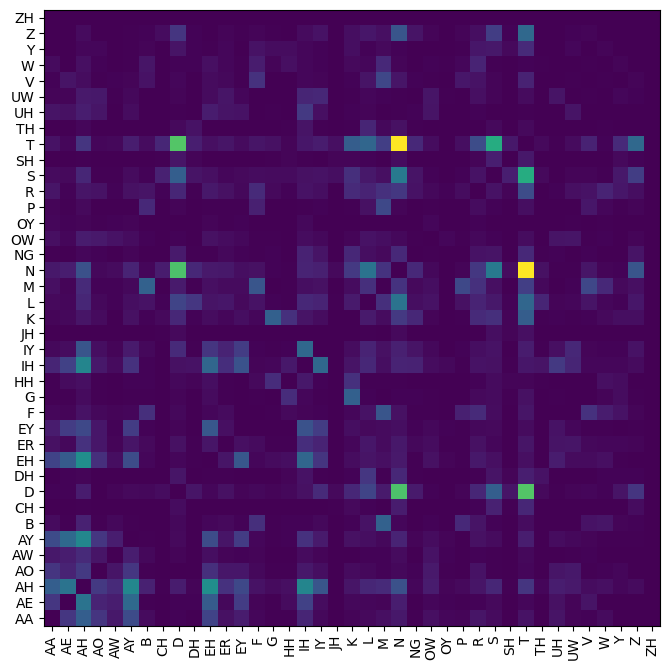

In [197]:
plt.figure(figsize=(8,8))
plt.imshow(confmat_all)
plt.xticks(ticks=np.arange(len(phonemes)),labels=phonemes,rotation=90,)
plt.yticks(ticks=np.arange(len(phonemes)),labels=phonemes,rotation=0,)
plt.ylim(0-.5,39-.5,)
plt.show()

In [165]:
phpos.max(-1)<0.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [163]:
phpos.shape

(75, 41)

In [158]:
confmat_all

array([[0.0000000e+00, 8.4261699e-03, 7.7943288e-05, ..., 1.7010389e-04,
        4.2413137e-04, 4.3906452e-06],
       [8.4261699e-03, 0.0000000e+00, 5.5508412e-05, ..., 2.3494766e-04,
        2.5388930e-04, 1.8448701e-06],
       [7.7943288e-05, 5.5508412e-05, 0.0000000e+00, ..., 4.1534158e-06,
        5.3617146e-06, 1.0372881e-08],
       ...,
       [1.7010389e-04, 2.3494766e-04, 4.1534158e-06, ..., 0.0000000e+00,
        2.0276464e-06, 1.7287427e-07],
       [4.2413137e-04, 2.5388930e-04, 5.3617146e-06, ..., 2.0276464e-06,
        0.0000000e+00, 4.5771708e-07],
       [4.3906452e-06, 1.8448701e-06, 1.0372881e-08, ..., 1.7287427e-07,
        4.5771708e-07, 0.0000000e+00]], dtype=float32)

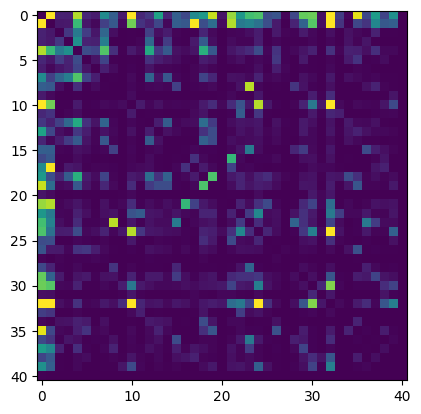

In [161]:
plt.imshow(confmat_all,vmax=8.4261699e-04)

In [131]:
ecog_file

'/home/cheoljun/bravo_packaged_data/tm1k/hgr_0.npy'

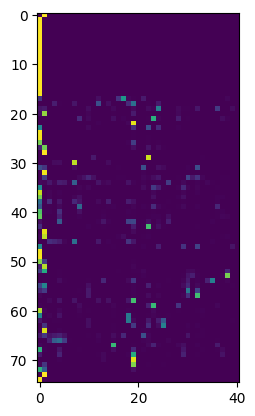

In [132]:

plt.imshow(phpos)

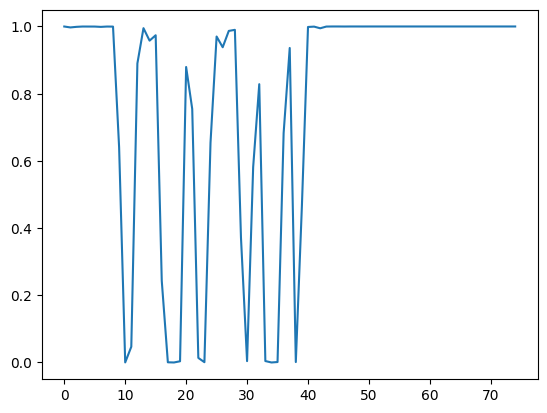

In [61]:
plt.plot(phpos[:,:2].sum(-1))